In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install tensorflow==2.9.1

In [ ]:
tf.__version__

'2.9.1'

In [ ]:
gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train = gen.flow_from_directory("/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_1000",
                                                            target_size=(64, 64), subset="training",batch_size=256)
val = gen.flow_from_directory("/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_1000",
                                                            target_size=(64, 64), subset="validation",batch_size=256)

Found 18820 images belonging to 26 classes.
Found 2077 images belonging to 26 classes.


In [ ]:
from pathlib import Path
# Create a list with the filepaths for training and testing
dir_ = Path('/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_1000')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [ ]:
import pandas as pd

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 20897

Number of different labels: 26

Labels: ['U' 'Y' 'K' 'N' 'Q' 'T' 'W' 'I' 'D' 'G' 'L' 'O' 'A' 'C' 'S' 'R' 'X' 'V'
 'B' 'P' 'Z' 'J' 'F' 'E' 'H' 'M']


,Filepath,Label
0,/content/drive/MyDrive/Final_year_project/ASL_...,U
1,/content/drive/MyDrive/Final_year_project/ASL_...,Y
2,/content/drive/MyDrive/Final_year_project/ASL_...,K
3,/content/drive/MyDrive/Final_year_project/ASL_...,N
4,/content/drive/MyDrive/Final_year_project/ASL_...,Q


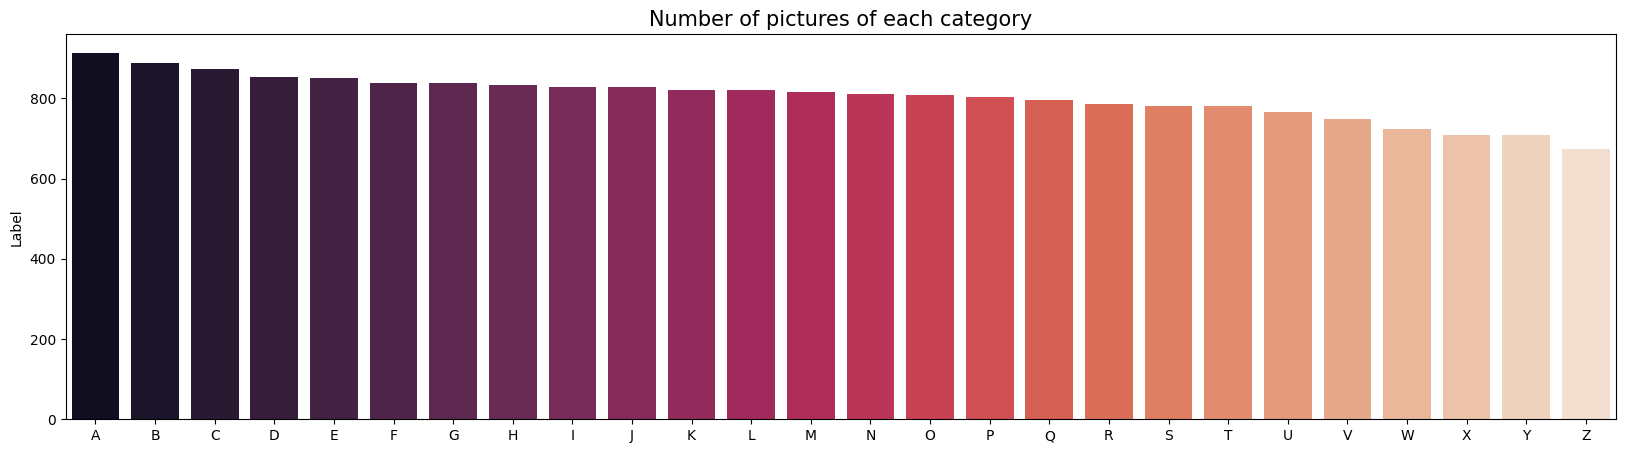

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

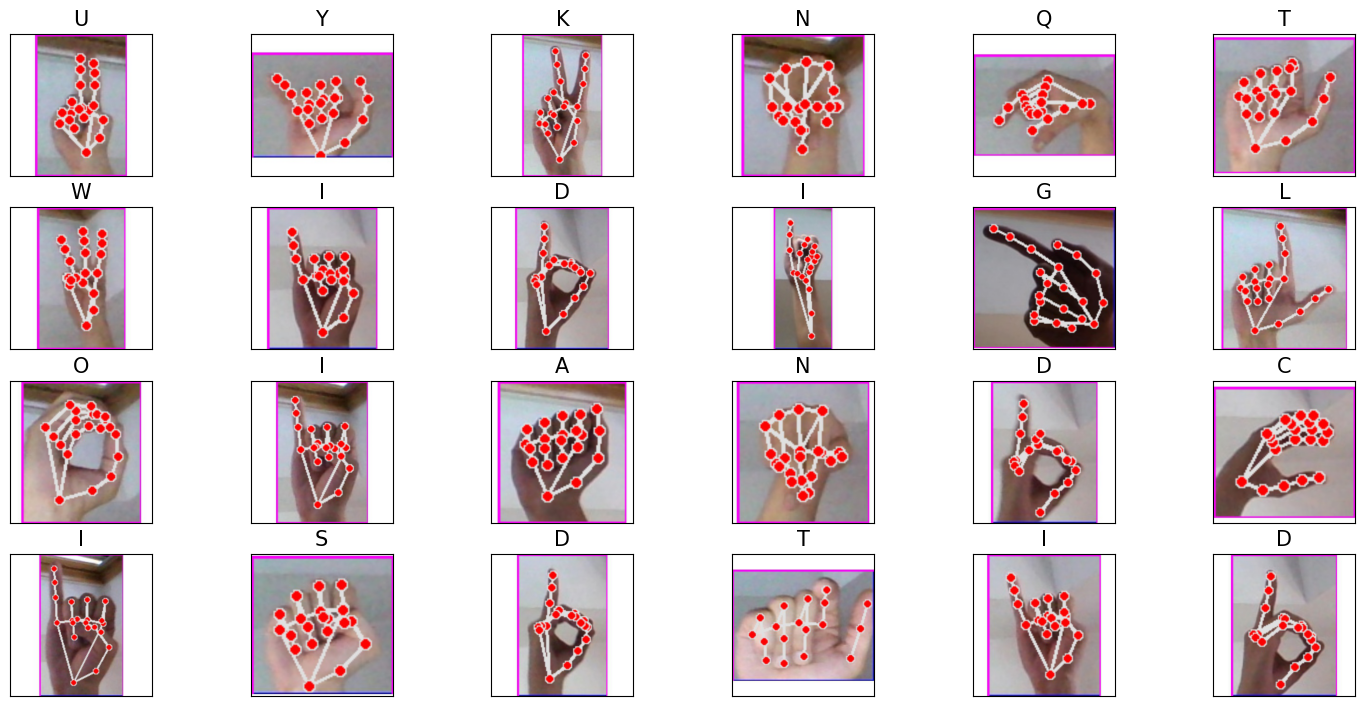

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
model = keras.Sequential()
model.add(VGG16(weights="imagenet",input_shape=(64,64,3),include_top=False))
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))
model.add(Dropout(0.3))
model.add(Dense(26,activation="softmax"))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
opt = Adam(0.00001)
loss = CategoricalCrossentropy()

In [ ]:
model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

In [ ]:
import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import os

model_directory='/content/drive/MyDrive/Final_year_project' # directory to save model history after every epoch

class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(model_directory)):
      with open(model_directory+'model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open(model_directory+'model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)


#model.fit(...,callbacks=[StoreModelHistory()])

In [ ]:
early_stopping_cb= tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5,restore_best_weights=True)

CKPT_path="/content/drive/MyDrive/Final_year_project/model_ckpt_note5_CROP1000.h5"
checkpointing_cb=tf.keras.callbacks.ModelCheckpoint(CKPT_path,save_best_only=True)

CALLBACK_LIST=[early_stopping_cb,checkpointing_cb,StoreModelHistory()]

In [ ]:
history = model.fit(train,validation_data = val,epochs = 10,shuffle = True,verbose = 1, callbacks = CALLBACK_LIST)

Epoch 1/10
 2/74 [..............................] - ETA: 1:08:02 - loss: 3.8009 - accuracy: 0.0352

In [ ]:
model_name = '/content/drive/MyDrive/Final_year_project/hand_sign_recognition_inceptionV3_note_5_1_crop1000.h5'
model.save(model_name, save_format='h5')

In [ ]:
ckpt_model=tf.keras.models.load_model(CKPT_path)

history=ckpt_model.fit(train,validation_data = val,epochs = 10,shuffle = True,verbose = 1, callbacks = CALLBACK_LIST)

Epoch 1/10
74/74 [==============================] - 4862s 65s/step - loss: 0.1403 - accuracy: 0.9751 - val_loss: 0.2883 - val_accuracy: 0.9605
Epoch 2/10
74/74 [==============================] - 4463s 60s/step - loss: 0.1040 - accuracy: 0.9817 - val_loss: 0.1957 - val_accuracy: 0.9653
Epoch 3/10
74/74 [==============================] - 4411s 60s/step - loss: 0.0815 - accuracy: 0.9856 - val_loss: 0.1596 - val_accuracy: 0.9658
Epoch 4/10
74/74 [==============================] - 4336s 59s/step - loss: 0.0672 - accuracy: 0.9873 - val_loss: 0.1453 - val_accuracy: 0.9663
Epoch 5/10
74/74 [==============================] - 4323s 58s/step - loss: 0.0550 - accuracy: 0.9897 - val_loss: 0.1476 - val_accuracy: 0.9653
Epoch 6/10
28/74 [==========>...................] - ETA: 43:37 - loss: 0.0507 - accuracy: 0.9900

In [ ]:
  model_name = '/content/drive/MyDrive/Final_year_project/hand_sign_recognition_inceptionV3_note_5_1_crop1000.h5'
  ckpt_model.save(model_name, save_format='h5')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

EPOCH = 10 # number of epochs the model has trained for

history_dataframe = pd.read_csv(model_directory+'model_history.csv',sep=',')


# Plot training & validation loss values
plt.style.use("ggplot")
plt.plot(range(1,EPOCH+1),
         history_dataframe['loss'])
plt.plot(range(1,EPOCH+1),
         history_dataframe['val_loss'],
         linestyle='--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Final_year_project/vgg_16_new_data.h5')

In [ ]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(r"/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_full_tes", target_size=(64, 64), class_mode=None)

Found 26 images belonging to 1 classes.


In [ ]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(r"/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_full_tes",
                                                            target_size=(64, 64), class_mode=None)
pred = model.predict(test)
class_names= ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
pred = np.argmax(pred, axis=1)
pred

Found 26 images belonging to 1 classes.
1/1 [==============================] - 1s 1s/step


array([ 9, 24,  1,  2, 13,  9, 17, 15,  4, 23, 25,  5,  8,  0, 16, 10,  7,
       14, 22, 13, 10,  3,  4, 11,  6, 20])

In [ ]:
print(pred[0:10])

[ 9 24  1  2 13  9 17 15  4 23]


In [ ]:
pred = model.predict(test)
print(pred)

In [ ]:
pred = model.predict(test)
for i in pred:
    print(np.argmax(i))

1/1 [==============================] - 2s 2s/step
13
9
20
4
14
1
13
10
22
11
16
2
4
15
0
3
8
5
17
24
6
7
25
23
9
10


In [ ]:
class_names= ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [ ]:
count=0
for i in pred:
    print(class_names[np.argmax(i)])
    count=count+1

print(count)


Found 27 images belonging to 1 classes.
1/1 [==============================] - 1s 1s/step


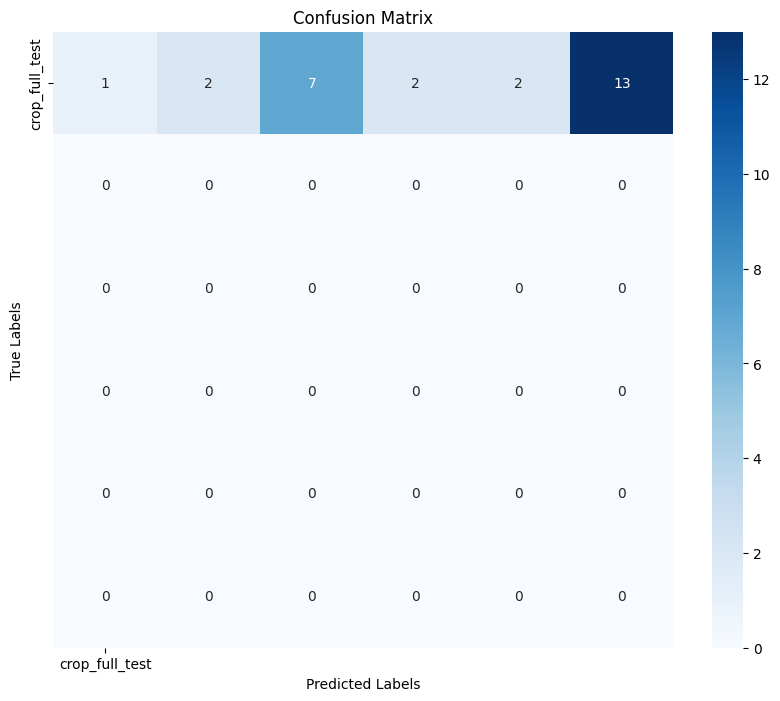

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
model = keras.models.load_model('/content/drive/MyDrive/Final_year_project/vgg_16_new_data.h5')

# Set up the ImageDataGenerator for test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Modify with your desired preprocessing steps

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_full_tes',
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve true labels from the test generator
true_labels = test_generator.classes

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 [==============================] - 2s 2s/step


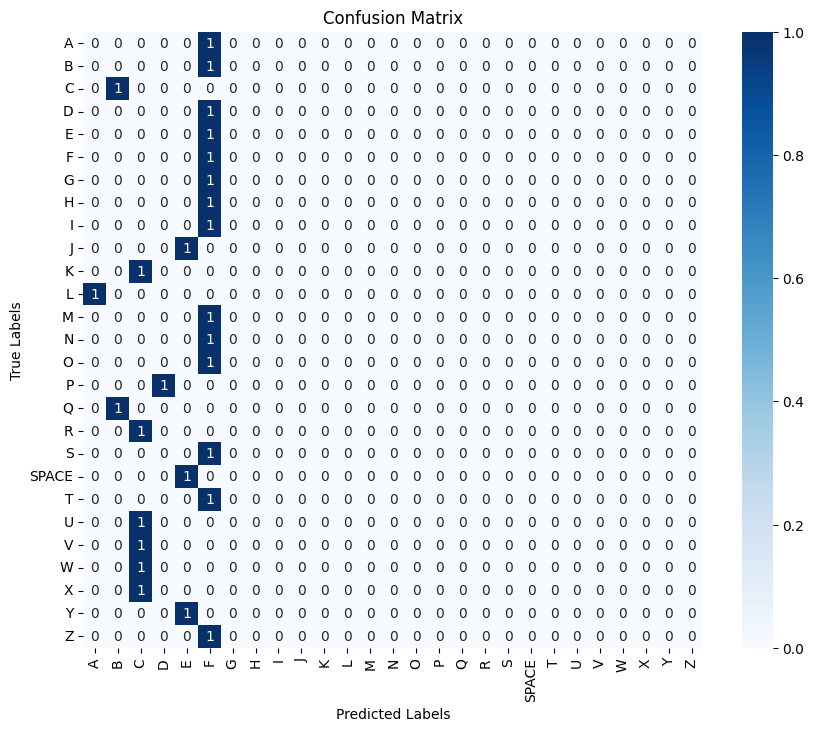

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image

# Load your trained model
model = keras.models.load_model('/content/drive/MyDrive/Final_year_project/vgg_16_new_data.h5')

# Set up the ImageDataGenerator for test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Modify with your desired preprocessing steps

# Path to your test dataset folder
test_folder = '/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_full_tes/crop_full_test'


# Define the desired input shape of the model
input_shape = (64, 64, 3)

# Generate predictions
test_images = []
true_labels = []

for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path)
    image = image.resize((input_shape[0], input_shape[1]))  # Resize the image
    image = np.array(image)
    image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    test_images.append(image)
    true_labels.append(image_name.split('_')[0])  # Extract class label from image name

test_images = np.array(test_images)
true_labels = np.array(true_labels)

# Convert true labels to numeric class indices
class_labels = np.unique(true_labels)
class_indices = {label: i for i, label in enumerate(class_labels)}
true_labels = np.array([class_indices[label] for label in true_labels])

# Generate predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(r"/content/drive/MyDrive/Final_year_project/ASL_media_dataset/crop_full_tes", target_size=(64, 64), class_mode=None)
test_preds = model.predict(test)
test_pred_labels = np.argmax(test_preds, axis=1)
cm = confusion_matrix(test_generator.classes, test_pred_labels)
print(cm)

Found 27 images belonging to 1 classes.
1/1 [==============================] - 2s 2s/step
[[ 1  2  7  2  2 13]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV files
model1_data = pd.read_csv('/content/drive/MyDrive/Final_year_project/inception_v3_log.csv')
model2_data = pd.read_csv('/content/drive/MyDrive/Final_year_project/crop_1000_log.csv')

# Get accuracy and loss values
model1_acc = model1_data['Accuracy']
model1_loss = model1_data['loss']
model1_val_acc = model1_data['Val_Accuracy']
model1_val_loss = model1_data['Val_loss']

model2_acc = model2_data['accuracy']
model2_loss = model2_data['loss']
model2_val_acc = model2_data['val_accuracy']
model2_val_loss = model2_data['val_loss']

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(model1_val_acc, label='Inception v3 model Accuracy')
plt.plot(model2_val_acc, label='VGG-16 model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(model1_val_loss, label='Inception v3 model Loss')
plt.plot(model2_val_loss, label='VGG-16 model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()
plt.grid(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
